# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [0]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [0]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


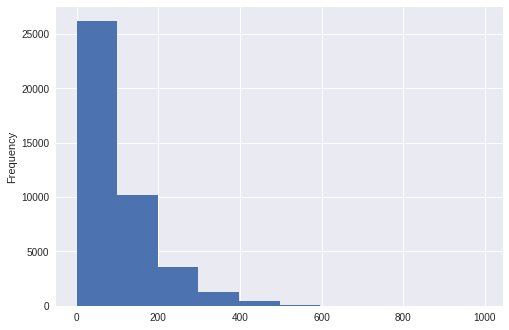

In [0]:
df['pm2.5'].plot.hist();

In [0]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2590006399659215

In [0]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# Also, these formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

pm25 ~ No + year + month + day + hour + DEWP + TEMP + PRES + Iws + Is + Ir


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.1600
Model:                       QuantReg   Bandwidth:                       8.276
Method:                 Least Squares   Sparsity:                        133.8
Date:                Mon, 21 Jan 2019   No. Observations:                41757
Time:                        00:41:20   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004   1.67e-05     22.881      0.000       0.000       0.000
No           3.63e-07   2.67e-05      0.014      0.989    -5.2e-05    5.27e-05
year           0.8830      0.031     28.631      0.000       0.823       0.943
month         -1.4110      0.103    -13.749      0.000      -1.612      -1.210
day            0.4461      0.037     11.951      0.000       0.373       0.519
hour           1.2810      0.050     25.779      0.000       1.184       1.378
DEWP           3.6362      0.047     77.315      0.000       3.544       3.728
TEMP          -4.7103      0.060    -78.779      0.000      -4.828      -4.593
PRES          -1.6265      0.061    -26.760      0.000      -1.746      -1.507
Iws           -0.1541      0.007    -21.786      0.000      -0.168      -0.140
Is            -1.6322      0.425     -3.838      0.000      -2.466      -0.799
Ir            -5.3946      0.234    -23.034      0.000      -5.854      -4.936
==============================================================================

The condition number is large, 3.67e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [0]:
help(quant_mod.fit)

Help on method fit in module statsmodels.regression.quantile_regression:

fit(q=0.5, vcov='robust', kernel='epa', bandwidth='hsheather', max_iter=1000, p_tol=1e-06, **kwargs) method of statsmodels.regression.quantile_regression.QuantReg instance
    Solve by Iterative Weighted Least Squares
    
    Parameters
    ----------
    q : float
        Quantile must be between 0 and 1
    vcov : string, method used to calculate the variance-covariance matrix
        of the parameters. Default is ``robust``:
    
        - robust : heteroskedasticity robust standard errors (as suggested
          in Greene 6th edition)
        - iid : iid errors (as in Stata 12)
    
    kernel : string, kernel to use in the kernel density estimation for the
        asymptotic covariance matrix:
    
        - epa: Epanechnikov
        - cos: Cosine
        - gau: Gaussian
        - par: Parzene
    
    bandwidth: string, Bandwidth selection method in kernel density
        estimation for asymptotic covarian

In [0]:
quantiles = (.05, .96, .1)

for quantile in quantiles:
  print(quant_mod.fit(q=quantile).summary())

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:              0.04130
Model:                       QuantReg   Bandwidth:                       8.908
Method:                 Least Squares   Sparsity:                        120.7
Date:                Sun, 20 Jan 2019   No. Observations:                41757
Time:                        23:01:53   Df Residuals:                    41745
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.072e-05    6.4e-06      4.803      0.000    1.82e-05    4.33e-05
No         -6.994e-05   9.59e-06     -7.292      0.000   -8.87e-05   -5.11e-05
year           0.0998      0.012      8.275      0.000       0.076       0.123
month         -0.4536      0.034    -13.419      0.0

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [0]:
quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=df)
for quantile in range(50, 100):
  quantile /= 100
  quant_reg = quant_mod.fit(q=quantile)
  print((quantile, quant_reg.prsquared))

(0.5, 0.1447879336023583)
(0.51, 0.1453046499109799)
(0.52, 0.1457984456251047)
(0.53, 0.14627848333343263)
(0.54, 0.1467640446791706)
(0.55, 0.14733094668790292)
(0.56, 0.14787821797693512)
(0.57, 0.14840185621049273)
(0.58, 0.14892138273908107)
(0.59, 0.14946793972061212)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.6, 0.1500450836285967)
(0.61, 0.15066665485612274)
(0.62, 0.15131550520931825)
(0.63, 0.15201598245712966)
(0.64, 0.152815632180745)
(0.65, 0.15360133883660188)
(0.66, 0.15440046026580068)
(0.67, 0.15521251759239985)
(0.68, 0.15607615678951559)
(0.69, 0.15692695615298136)
(0.7, 0.1577663389046554)
(0.71, 0.15865286212994567)
(0.72, 0.15961363441229715)
(0.73, 0.16062991121153458)
(0.74, 0.1617151201897239)
(0.75, 0.16280951619867146)
(0.76, 0.16394259393342125)
(0.77, 0.16517451474458056)
(0.78, 0.1664423443710097)
(0.79, 0.16770815353095714)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.8, 0.16904227356438506)
(0.81, 0.17037126968955685)
(0.82, 0.17195593122357777)
(0.83, 0.17383892606382623)
(0.84, 0.17599918426382777)
(0.85, 0.17817588507328963)
(0.86, 0.18047434708570964)
(0.87, 0.18274842963575832)
(0.88, 0.1850748927825704)
(0.89, 0.18767194363846373)
(0.9, 0.1899871464061209)
(0.91, 0.19205778885867675)
(0.92, 0.19409258046839573)
(0.93, 0.1960928580149024)
(0.94, 0.1990718585613529)
(0.95, 0.20306510227274233)
(0.96, 0.20828854295993626)
(0.97, 0.21268428179968246)
(0.98, 0.21668870123970496)
(0.99, 0.21742941318156628)


In [0]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
quant_reg.summary()  # "summary" is another very R-thing

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.2614
Model:                       QuantReg   Bandwidth:                     0.01908
Method:                 Least Squares   Sparsity:                       0.6060
Date:                Mon, 21 Jan 2019   No. Observations:                41757
Time:                        00:41:40   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.016e-06   6.52e-08     15.579      0.000    8.88e-07    1.14e-06
No         -7.472e-07   1.01e-07     -7.406      0.000   -9.45e-07   -5.49e-07
year           0.0027      0.000     21.867      0.000       0.002       0.003
month         -0.0075      0.000    -19.825      0.000      -0.008      -0.007
day            0.0014      0.000      9.770      0.000       0.001       0.002
hour           0.0049      0.000     23.971      0.000       0.004       0.005
DEWP           0.0155      0.000     89.454      0.000       0.015       0.016
TEMP          -0.0172      0.000    -77.079      0.000      -0.018      -0.017
PRES          -0.0036      0.000    -14.870      0.000      -0.004      -0.003
Iws           -0.0010   2.42e-05    -39.707      0.000      -0.001      -0.001
Is            -0.0025      0.002     -1.517      0.129      -0.006       0.001
Ir            -0.0235      0.001    -29.010      0.000      -0.025      -0.022
==============================================================================

The condition number is large, 3.67e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [0]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [50]:
import pandas as pd
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [51]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


In [52]:
# TODO - your work here! Also, add text cells for written questions.
bwt_df.info() #No NaNs - YAY

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 7 columns):
bwt          1174 non-null int64
gestation    1174 non-null int64
parity       1174 non-null int64
age          1174 non-null int64
height       1174 non-null int64
weight       1174 non-null int64
smoke        1174 non-null int64
dtypes: int64(7)
memory usage: 64.3 KB


In [53]:
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# They can also support * for interaction terms and polynomials
# y ~ x1 + (x1 * x1) + x2 + (x1 * x2)

# Now let's construct the formula string using all columns
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + parity + age + height + weight + smoke


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1365
Model:                       QuantReg   Bandwidth:                       6.851
Method:                 Least Squares   Sparsity:                        37.19
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        15:43:48   Df Residuals:                     1167
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -93.3364     16.853     -5.538      0.000    -126.402     -60.271
gestation      0.4868      0.034     14.242      0.000       0.420       0.554
parity        -2.2658      1.326     -1.709      0.088      -4.868       0.336
age           -0.0015      0.101     -0.015      0.988      -0.199       0.196
height         1.1192      0.241      4.647      0.000       0.647       1.592
weight         0.0684      0.030      2.308      0.021       0.010       0.127
smoke         -8.0711      1.120     -7.203      0.000     -10.269      -5.873
==============================================================================

The condition number is large, 9.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
import numpy as np
#adding bmi since it's a better indicator of health of a specific person
bwt_df['bmi'] = bwt_df['weight']*.45 / (bwt_df['height']*.025)**2
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke,bmi
0,120,284,0,27,62,100,0,18.730489
1,113,282,0,33,64,135,0,23.730469
2,128,279,0,28,64,115,1,20.214844
3,108,282,0,23,67,125,1,20.049009
4,136,286,0,25,62,93,0,17.419355


In [55]:
#Looking for our 90 ounce percentile

bwt_df.describe(percentiles = [.05,.055,.06,.07])

,bwt,gestation,parity,age,height,weight,smoke,bmi
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971,22.530180
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176,3.301616
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000,16.039207
5%,88.000000,251.650000,0.000000,19.000000,60.000000,101.650000,0.000000,18.730489
5.5%,90.000000,253.515000,0.000000,19.000000,60.000000,102.000000,0.000000,18.738252
6%,91.000000,254.380000,0.000000,19.000000,60.000000,103.000000,0.000000,18.745562
7.0%,93.000000,256.000000,0.000000,20.000000,60.000000,103.000000,0.000000,18.917108
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000,21.796875
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000,41.322314


In [56]:
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.055)
quant_reg.summary() 

bwt ~ gestation + parity + age + height + weight + smoke + bmi


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2007
Model:                       QuantReg   Bandwidth:                       6.294
Method:                 Least Squares   Sparsity:                        129.1
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        15:43:57   Df Residuals:                     1166
                                        Df Model:                            7
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -181.3669    142.118     -1.276      0.202    -460.202      97.469
gestation      0.4795      0.088      5.477      0.000       0.308       0.651
parity        -3.5159      2.270     -1.549      0.122      -7.970       0.938
age           -0.0533      0.170     -0.313      0.754      -0.387       0.281
height         2.5661      2.217      1.157      0.247      -1.785       6.917
weight        -0.4693      0.525     -0.894      0.372      -1.499       0.561
smoke         -9.0315      1.803     -5.008      0.000     -12.569      -5.494
bmi            1.9417      2.965      0.655      0.513      -3.876       7.759
==============================================================================

The condition number is large, 5.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
#Checking for multicollinearity

new_df = bwt_df.drop('bwt', axis='columns')

from statsmodels.stats.outliers_influence import variance_inflation_factor

print(new_df.columns, '\n\n')

vif = [variance_inflation_factor(new_df.values, i) for i in range(new_df.shape[1])]
print(vif)

# Gestation, age, height, weight, bmi, age_per_weight, and height_per_weight all have high VIF

Index(['gestation', 'parity', 'age', 'height', 'weight', 'smoke', 'bmi'], dtype='object') 


[307.5207940370727, 1.5666536335116839, 26.702451239203562, 386.15727142639264, 244.8011251747489, 1.6668670294165973, 234.49039486968312]


In [58]:
new_df.corr()
# Looks like weight and bmi are pretty highly correlated. 
#bmi had a better p value, so I'll drop weight
#Age also has a high p value and low coef, so I'll try dropping that too

,gestation,parity,age,height,weight,smoke,bmi
gestation,1.000000,0.080916,-0.053425,0.070470,0.023655,-0.060267,-0.011891
parity,0.080916,1.000000,-0.351041,0.043543,-0.096362,-0.009599,-0.129255
age,-0.053425,-0.351041,1.000000,-0.006453,0.147322,-0.067772,0.165408
height,0.070470,0.043543,-0.006453,1.000000,0.435287,0.017507,-0.062455
weight,0.023655,-0.096362,0.147322,0.435287,1.000000,-0.060281,0.868344
smoke,-0.060267,-0.009599,-0.067772,0.017507,-0.060281,1.000000,-0.074903
bmi,-0.011891,-0.129255,0.165408,-0.062455,0.868344,-0.074903,1.000000


In [59]:
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop(['bwt','weight','age'], axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.055)
quant_reg.summary() 

#parity has a high p value and std err, let's try dropping it

bwt ~ gestation + parity + height + smoke + bmi


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1993
Model:                       QuantReg   Bandwidth:                       6.195
Method:                 Least Squares   Sparsity:                        136.1
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        15:44:12   Df Residuals:                     1168
                                        Df Model:                            5
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -78.8283     33.438     -2.357      0.019    -144.434     -13.222
gestation      0.4915      0.093      5.303      0.000       0.310       0.673
parity        -3.0925      2.156     -1.434      0.152      -7.323       1.138
height         0.8481      0.394      2.151      0.032       0.075       1.622
smoke         -8.6996      1.896     -4.588      0.000     -12.420      -4.979
bmi           -0.6234      0.323     -1.931      0.054      -1.257       0.010
==============================================================================

The condition number is large, 8.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop(['bwt','weight','age','parity'], axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.055)
quant_reg.summary() 

bwt ~ gestation + height + smoke + bmi


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1966
Model:                       QuantReg   Bandwidth:                       6.262
Method:                 Least Squares   Sparsity:                        129.1
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        17:44:20   Df Residuals:                     1169
                                        Df Model:                            4
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -73.7075     32.247     -2.286      0.022    -136.975     -10.440
gestation      0.4727      0.088      5.381      0.000       0.300       0.645
height         0.8370      0.368      2.274      0.023       0.115       1.559
smoke         -9.2426      1.788     -5.170      0.000     -12.750      -5.735
bmi           -0.5867      0.308     -1.907      0.057      -1.190       0.017
==============================================================================

The condition number is large, 8.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [151]:
h_bwt = pd.DataFrame(bwt_df[['bwt','bmi']])
h_bwt.head()

,bwt,bmi
0,120,18.730489
1,113,23.730469
2,128,20.214844
3,108,20.049009
4,136,17.419355


In [152]:
quant_formula = 'bwt ~ ' + ' + '.join(h_bwt.drop(['bwt'],axis=1).columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=h_bwt)
quant_reg = quant_mod.fit(q=.055)
quant_reg.summary()

bwt ~ bmi


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:            2.222e-05
Model:                       QuantReg   Bandwidth:                       6.814
Method:                 Least Squares   Sparsity:                        213.3
Date:                Thu, 24 Jan 2019   No. Observations:                 1174
Time:                        14:58:23   Df Residuals:                     1172
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     92.1043     10.607      8.683      0.000      71.293     112.916
bmi           -0.1105      0.466     -0.237      0.813      -1.025       0.804
==============================================================================
"""

In [153]:
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = quant_mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['bmi']] + \
            res.conf_int().loc['bmi'].tolist()
    
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub'])

ols = smf.ols('bwt ~ bmi', h_bwt).fit()
ols_ci = ols.conf_int().loc['bmi'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['bmi'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


      q           a             b        lb        ub
0  0.05   88.000009 -4.227922e-07 -0.969791  0.969790
1  0.15   93.343435  3.366137e-01 -0.167464  0.840691
2  0.25   95.526739  5.646996e-01  0.082859  1.046540
3  0.35  106.076330  3.337965e-01 -0.060841  0.728434
4  0.45  109.643838  3.597197e-01 -0.018001  0.737440
5  0.55  113.763014  3.693879e-01  0.001270  0.737506
6  0.65  116.887679  4.092391e-01  0.048539  0.769939
7  0.75  123.191220  3.385957e-01 -0.047643  0.724835
8  0.85  132.344257  2.247160e-01 -0.249017  0.698449
9  0.95  126.923067  9.591883e-01  0.299041  1.619336
{'a': 111.48138646584292, 'b': 0.3542419391711743, 'lb': 0.03673630655693677, 'ub': 0.6717475717854118}


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


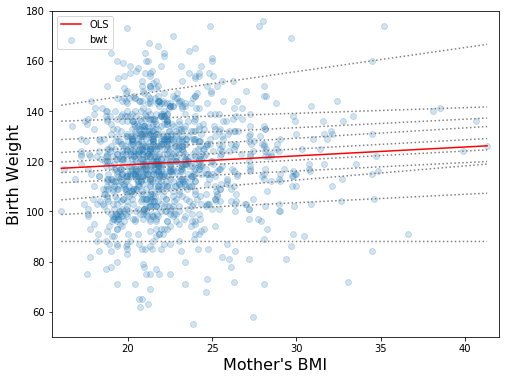

In [162]:
import matplotlib.pyplot as plt
x = np.arange(h_bwt.bmi.min(), h_bwt.bmi.max(), .01)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')
    
y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(h_bwt.bmi,h_bwt.bwt, alpha=.2)
ax.set_ylim((50, 180))
ax.set_xlim((15.5, 42))
legend = ax.legend()
ax.set_ylabel('Birth Weight', fontsize=16)
ax.set_xlabel("Mother's BMI", fontsize=16);

#Lower BMI could correlate with lower birth weight

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model